In [1]:
import pandas as pd

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [82]:
import numpy as np
np.random.seed(1000)
from tensorflow import set_random_seed
set_random_seed(2)
import datapreprocess as dp
reload(dp)
import matplotlib.pyplot as plt
from copy import deepcopy
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt2
import os
from dateutil import parser

from sklearn.externals import joblib
# if os.path.isdir("./models"):
#     shutil.rmtree("./models")

# os.makedirs("./models")

from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

reload(dp)
from statsmodels.tsa.arima_model import ARIMA

In [304]:
# Load file
file = 'test.csv'
data = pd.read_csv(file, sep = ',')
data = dp.remove_inc_variables(data, .1)
#skip first two data rows: missing
data.head(5)
dates = data['BusinessDate'].tolist()
data.index = pd.DatetimeIndex(freq='d', start = dates[0], periods = 367)

Variables: From 8 to 8


## Baselining

- To create a simple baseline, we will use the previous day's actual value as a prediction for period t

In [5]:
qs = data['Quantity Sold'].astype('float32').tolist()
dsr = data['DailyShoeRental'].astype('float32').tolist()
waep = data['WtAvgEffPrice'].str.strip('$').astype('float32').tolist()
qs_train, qs_test = qs[:-60], qs[-60:]
dsr_train, dsr_test = dsr[:-60], dsr[-60:]
waep_train, waep_test = waep[:-60], waep[-60:]
names = ['Quantity Sold','DailyShoeRental','WtAvgEffPrice']
indx = 0
for var in [qs,dsr,waep]:
    train, test = var[:-60], var[-60:]
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        # predict
        yhat = history[-1]
        predictions.append(yhat)
        # observation
        obs = test[i]
        history.append(obs)
#         print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    # report performance
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    print names[indx],'RMSE: %.3f' % rmse
    indx +=1

Quantity Sold RMSE: 263.339
DailyShoeRental RMSE: 143.474
WtAvgEffPrice RMSE: 1.553


## Data Exploration

### Observations:
- All 3 features have seasonalities
- no clear trending (potential horizontal trend)
- Need to check and possibly correct for non-stationarity

count     367.000000
mean      375.196198
std       255.802277
min         8.000000
25%       173.500000
50%       307.000000
75%       524.000000
max      1409.000000
Name: Quantity Sold, dtype: float64


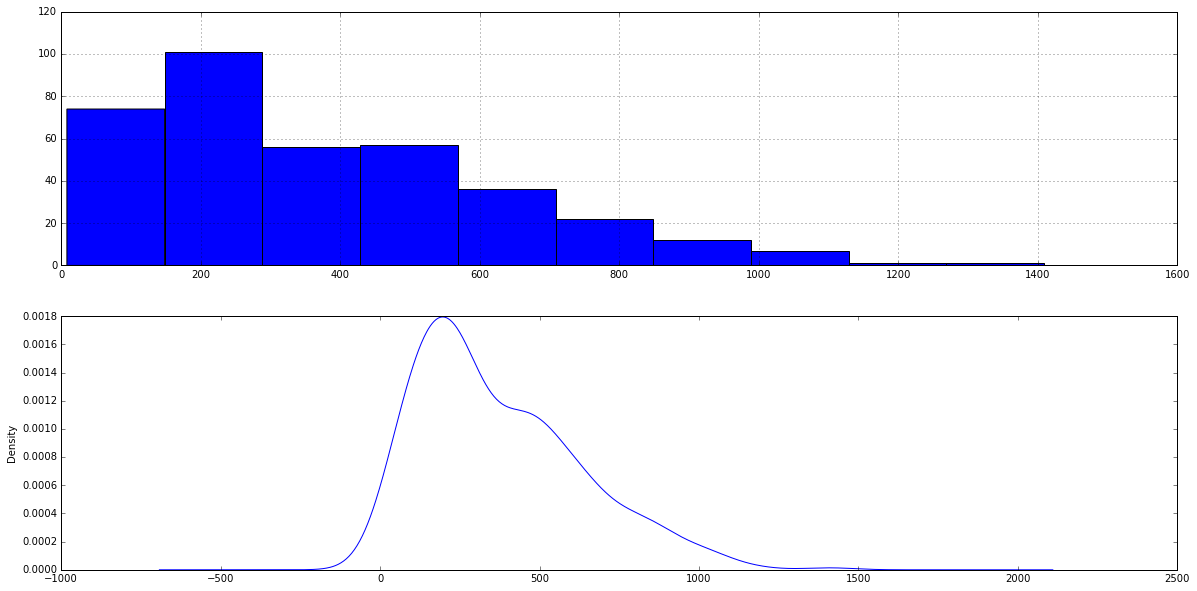

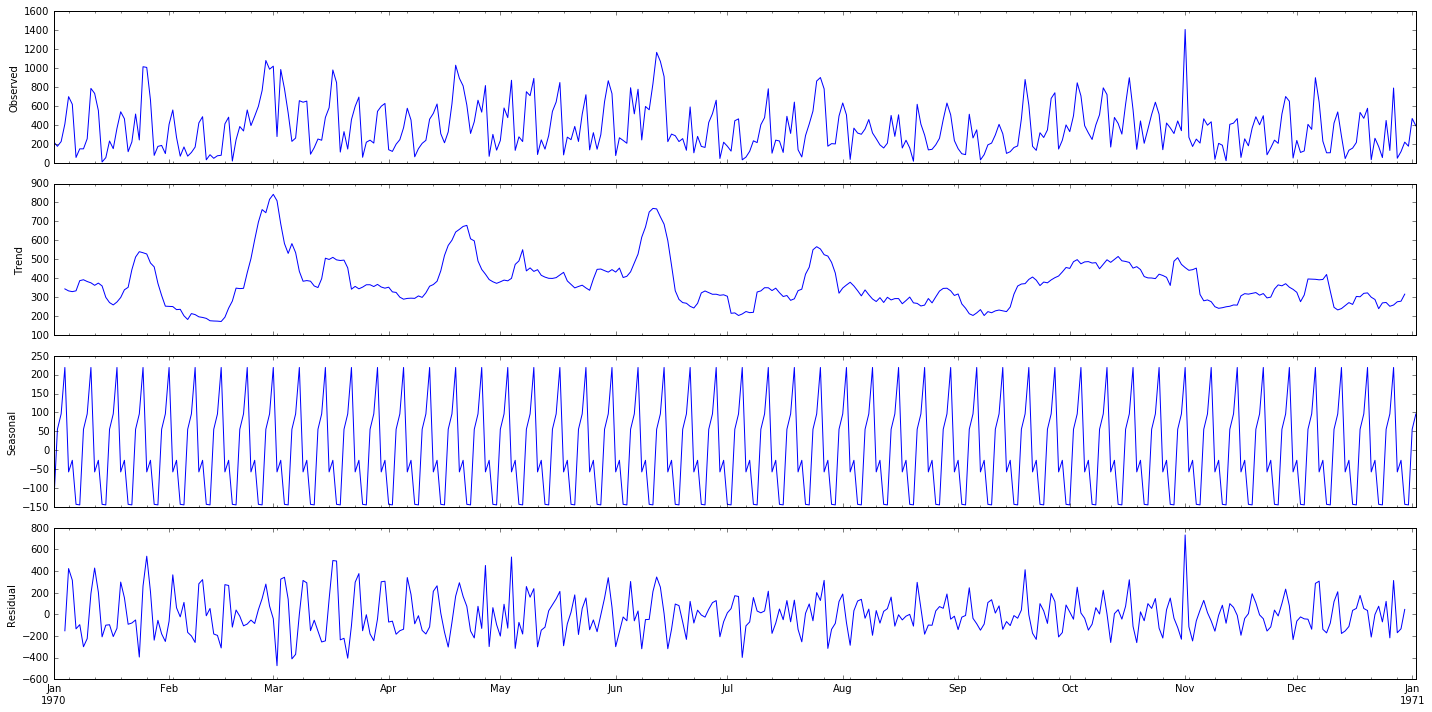

---
count    367.000000
mean     211.580383
std      149.093811
min        8.000000
25%       95.000000
50%      174.000000
75%      298.000000
max      856.000000
Name: DailyShoeRental, dtype: float64


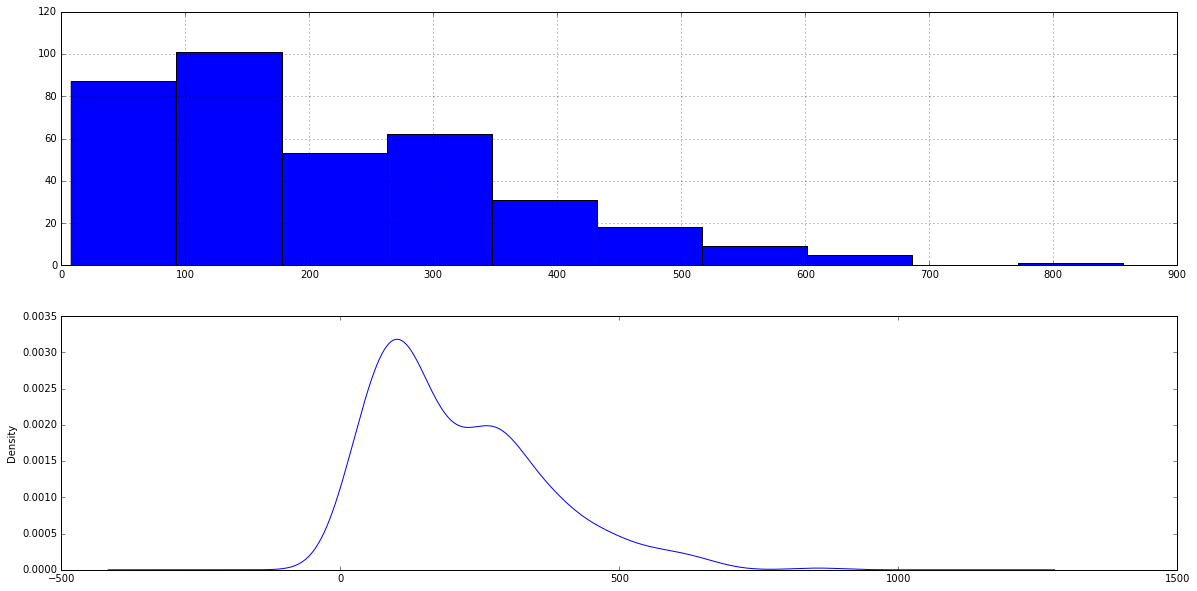

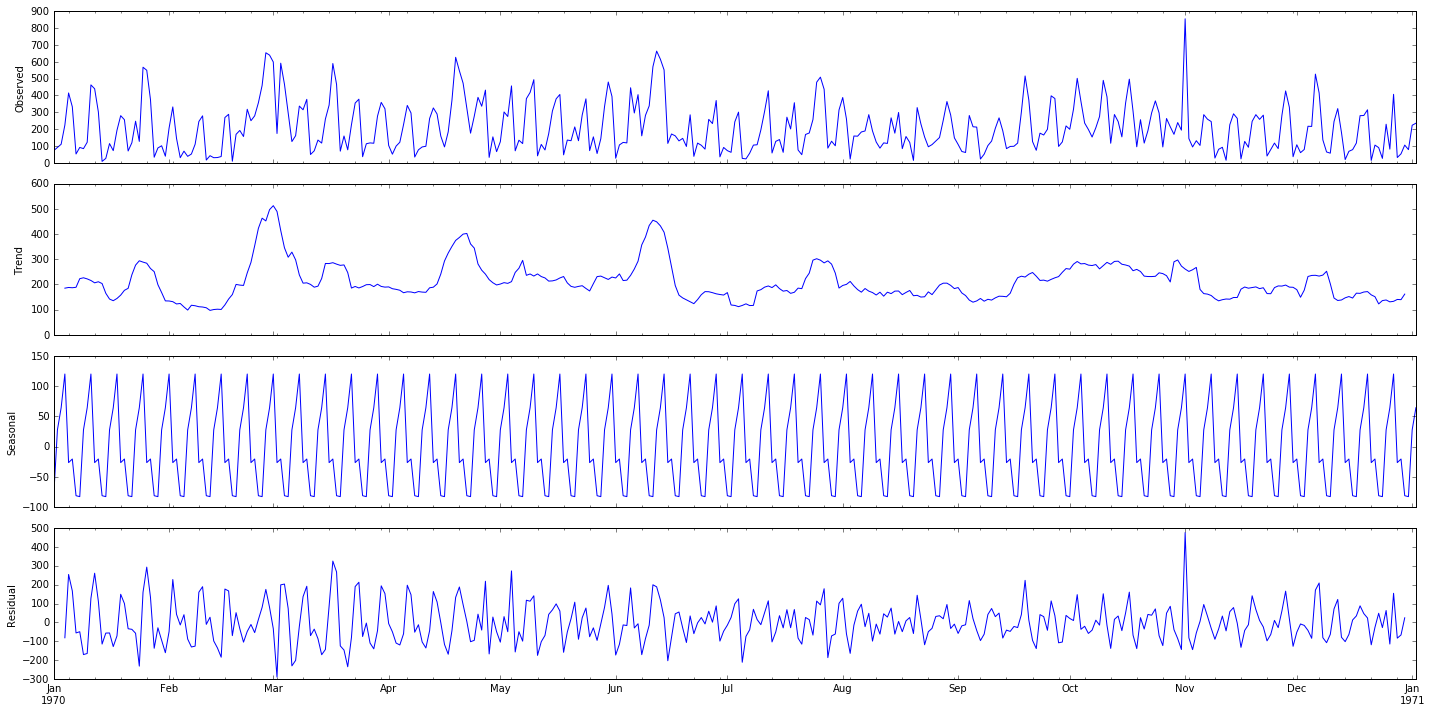

---
count    367.000000
mean      10.287248
std        1.336994
min        6.780000
25%       10.290000
50%       10.590000
75%       11.130000
max       12.290000
Name: WtAvgEffPrice, dtype: float64


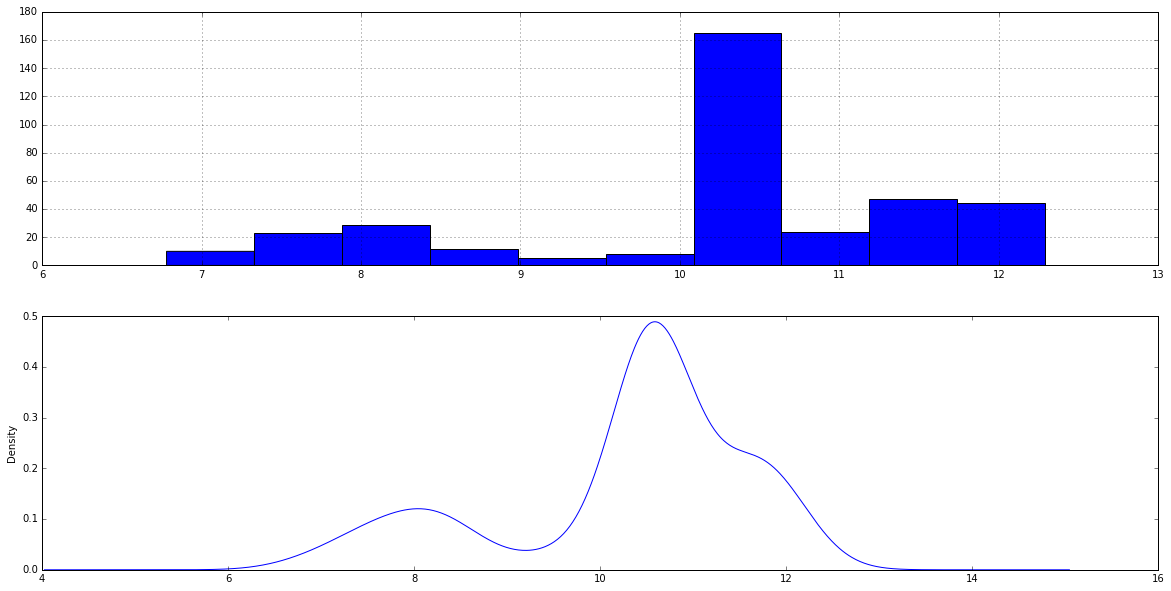

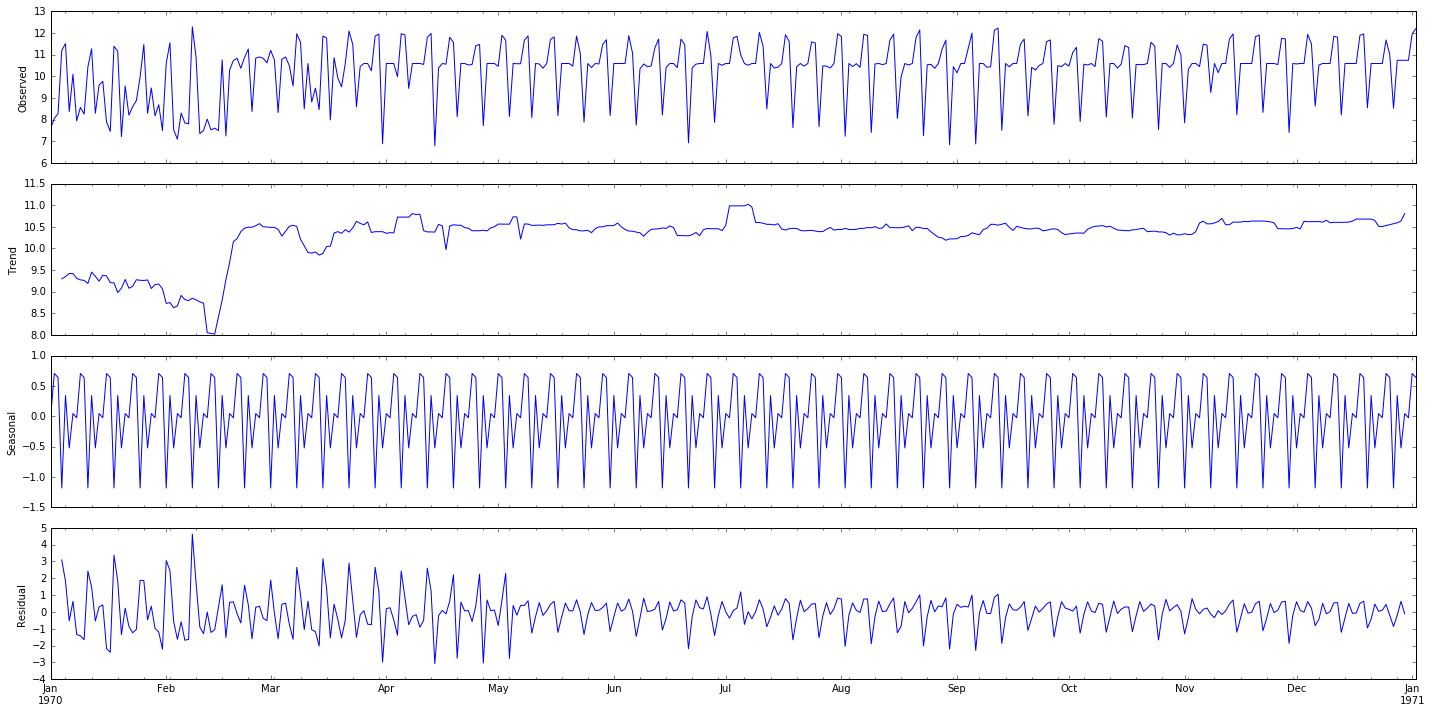

---


In [6]:
qs = data['Quantity Sold'].astype('float32')
dsr = data['DailyShoeRental'].astype('float32')
waep = data['WtAvgEffPrice'].str.strip('$').astype('float32')

for var in [qs,dsr,waep]:
    plt2.rcParams["figure.figsize"] = (20,10)
    print var.describe()
    plt2.figure(1)
    plt2.subplot(211)
    var.hist()
    plt2.subplot(212)
    var.plot(kind='kde')
    plt2.show()
    var = pd.DataFrame(var)
    var.index = pd.DatetimeIndex(freq='d', start = 0, periods = 367)
    decomp = seasonal_decompose(var, model='additive')
    decomp.plot()
    
    plt2.show()
    
    print '---'

## Checking for Stationarity

- after checking for stationarity, it looks like the first difference is enough... P-value is lower than a = 0.05 and/or test statistic < critical value
- after looking at the autocorrelation plots, seasonality seams to be affecting the series too much...
- since there is seasonality, we need to difference based on that... probably 7 days, since it looks like a weekly seasonality; I = 7

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=7)
    rolstd = pd.rolling_std(timeseries, window=7)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 

In [8]:
qs = pd.DataFrame(data['Quantity Sold'].astype('float32'))
qs.index = pd.DatetimeIndex(freq='d', start = dates[0], periods = 367)
dsr = pd.DataFrame(data['DailyShoeRental'].astype('float32'))
dsr.index = pd.DatetimeIndex(freq='d', start = dates[0], periods = 367)
waep = pd.DataFrame(data['WtAvgEffPrice'].str.strip('$').astype('float32'))
waep.index = pd.DatetimeIndex(freq='d', start = dates[0], periods = 367)

### Quantity Sold

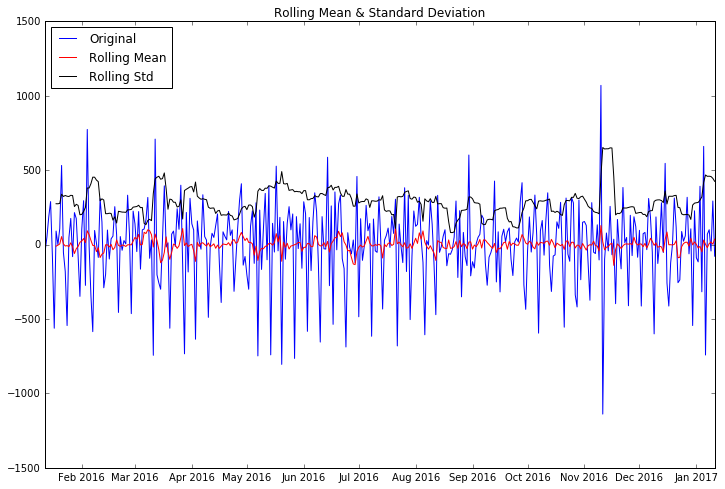

Results of Dickey-Fuller Test:
Test Statistic                -9.853283e+00
p-value                        4.427126e-17
#Lags Used                     1.200000e+01
Number of Observations Used    3.530000e+02
Critical Value (5%)           -2.869763e+00
Critical Value (1%)           -3.449011e+00
Critical Value (10%)          -2.571151e+00
dtype: float64


In [9]:
qs['first_difference'] = qs['Quantity Sold'] - qs['Quantity Sold'].shift(1)
test_stationarity(qs['first_difference'].dropna(inplace = False))

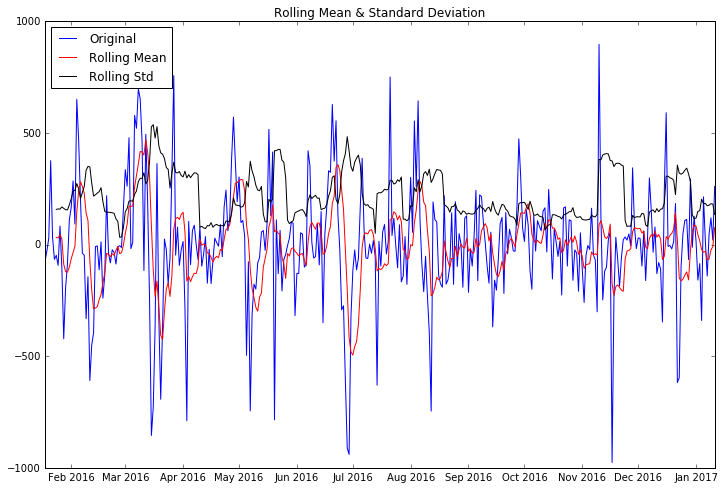

Results of Dickey-Fuller Test:
Test Statistic                  -5.569973
p-value                          0.000001
#Lags Used                      14.000000
Number of Observations Used    345.000000
Critical Value (5%)             -2.869954
Critical Value (1%)             -3.449447
Critical Value (10%)            -2.571253
dtype: float64


In [10]:
qs['seasonal_difference'] = qs['Quantity Sold'] - qs['Quantity Sold'].shift(7)
test_stationarity(qs['seasonal_difference'].dropna(inplace = False))

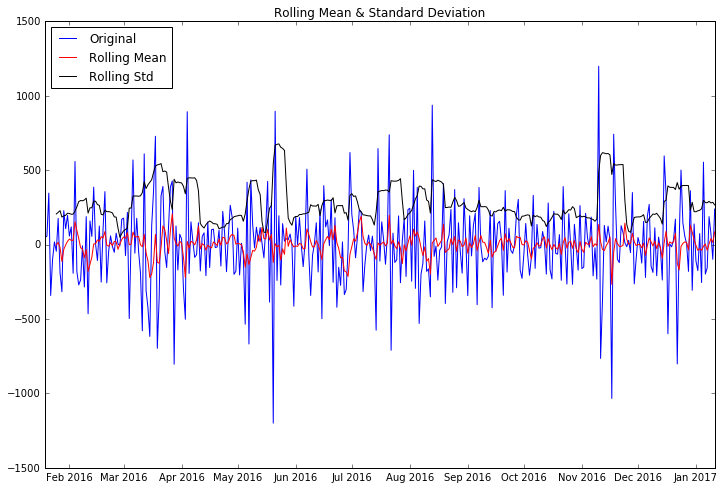

Results of Dickey-Fuller Test:
Test Statistic                -8.996297e+00
p-value                        6.680638e-15
#Lags Used                     1.300000e+01
Number of Observations Used    3.450000e+02
Critical Value (5%)           -2.869954e+00
Critical Value (1%)           -3.449447e+00
Critical Value (10%)          -2.571253e+00
dtype: float64


In [11]:
qs['seasonal_first_difference'] = qs['seasonal_difference'] - qs['seasonal_difference'].shift(1)
test_stationarity(qs['seasonal_first_difference'].dropna(inplace = False))

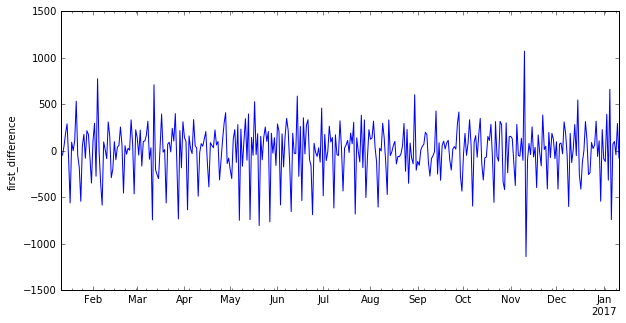

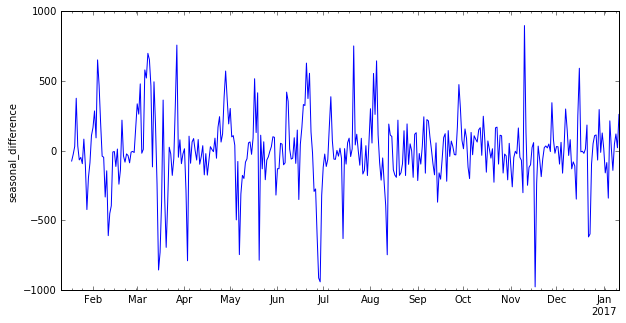

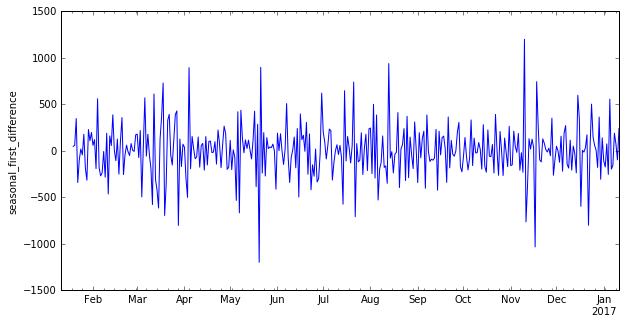

In [12]:
plt2.rcParams["figure.figsize"] = (10,5)
qs['first_difference'].plot()
plt2.ylabel('first_difference')
plt2.show()

qs['seasonal_difference'].plot()
plt2.ylabel('seasonal_difference')
plt2.show()

qs['seasonal_first_difference'].plot()
plt2.ylabel('seasonal_first_difference')
plt2.show()


### Daily Shoe Rental

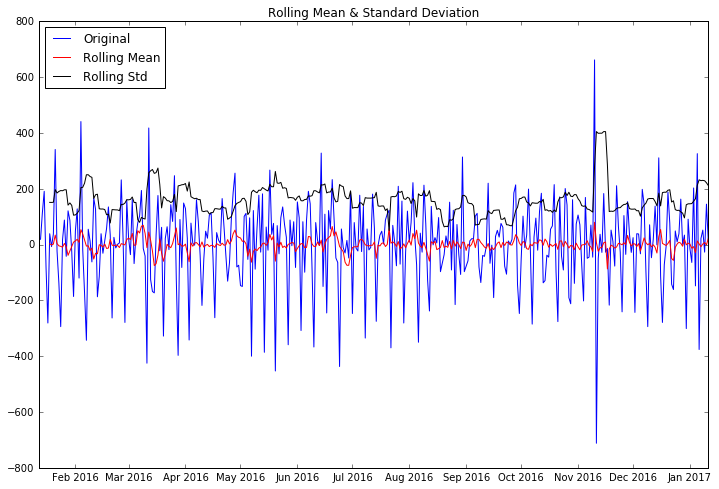

Results of Dickey-Fuller Test:
Test Statistic                -1.009554e+01
p-value                        1.093351e-17
#Lags Used                     1.200000e+01
Number of Observations Used    3.530000e+02
Critical Value (5%)           -2.869763e+00
Critical Value (1%)           -3.449011e+00
Critical Value (10%)          -2.571151e+00
dtype: float64


In [13]:
dsr['first_difference'] = dsr['DailyShoeRental'] - dsr['DailyShoeRental'].shift(1)
test_stationarity(dsr['first_difference'].dropna(inplace = False))

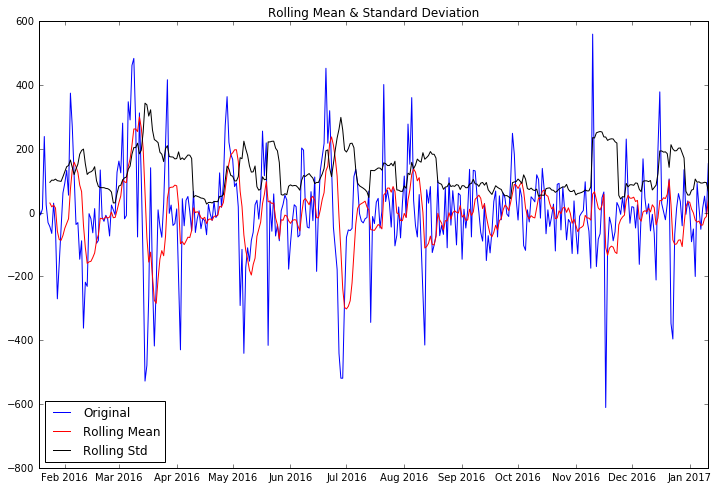

Results of Dickey-Fuller Test:
Test Statistic                -5.700970e+00
p-value                        7.677662e-07
#Lags Used                     1.400000e+01
Number of Observations Used    3.450000e+02
Critical Value (5%)           -2.869954e+00
Critical Value (1%)           -3.449447e+00
Critical Value (10%)          -2.571253e+00
dtype: float64


In [14]:
dsr['seasonal_difference'] = dsr['DailyShoeRental'] - dsr['DailyShoeRental'].shift(7)
test_stationarity(dsr['seasonal_difference'].dropna(inplace = False))

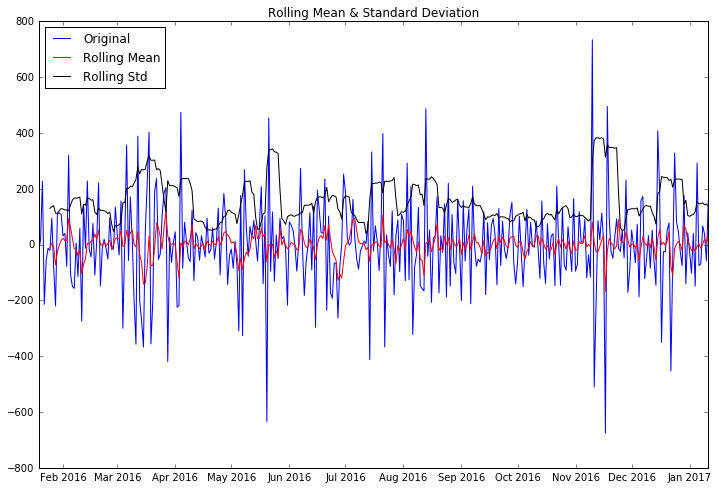

Results of Dickey-Fuller Test:
Test Statistic                -8.961214e+00
p-value                        8.214808e-15
#Lags Used                     1.300000e+01
Number of Observations Used    3.450000e+02
Critical Value (5%)           -2.869954e+00
Critical Value (1%)           -3.449447e+00
Critical Value (10%)          -2.571253e+00
dtype: float64


In [15]:
dsr['seasonal_first_difference'] = dsr['seasonal_difference'] - dsr['seasonal_difference'].shift(1)
test_stationarity(dsr['seasonal_first_difference'].dropna(inplace = False))

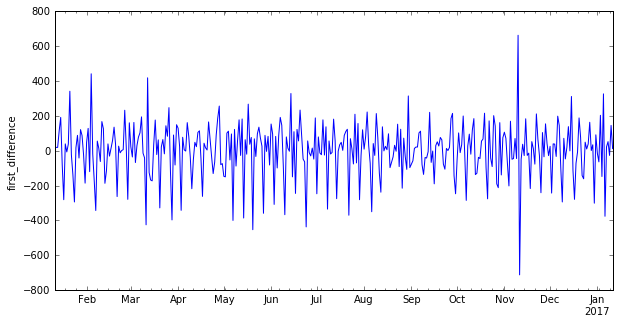

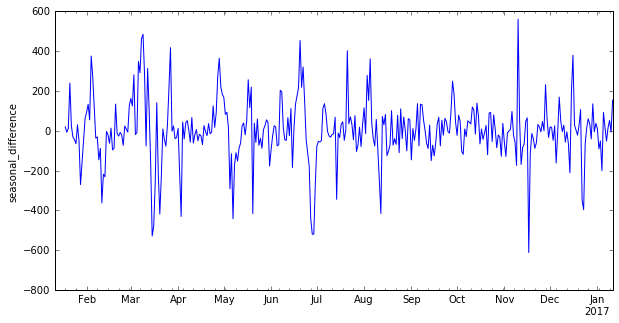

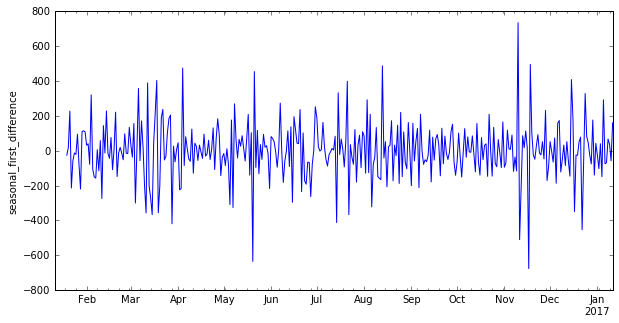

In [16]:
plt2.rcParams["figure.figsize"] = (10,5)
dsr['first_difference'].plot()
plt2.ylabel('first_difference')
plt2.show()

dsr['seasonal_difference'].plot()
plt2.ylabel('seasonal_difference')
plt2.show()

dsr['seasonal_first_difference'].plot()
plt2.ylabel('seasonal_first_difference')
plt2.show()


### WtAvgEffPrice

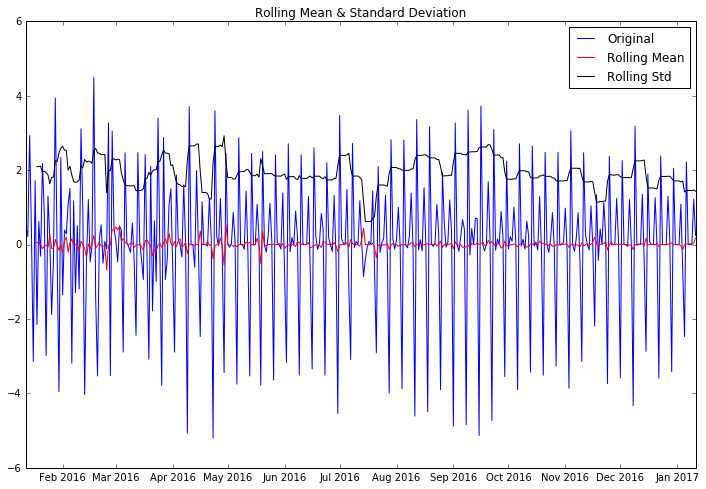

Results of Dickey-Fuller Test:
Test Statistic                -8.978482e+00
p-value                        7.420045e-15
#Lags Used                     1.200000e+01
Number of Observations Used    3.530000e+02
Critical Value (5%)           -2.869763e+00
Critical Value (1%)           -3.449011e+00
Critical Value (10%)          -2.571151e+00
dtype: float64


In [17]:
waep['first_difference'] = waep['WtAvgEffPrice'] - waep['WtAvgEffPrice'].shift(1)
test_stationarity(waep['first_difference'].dropna(inplace = False))

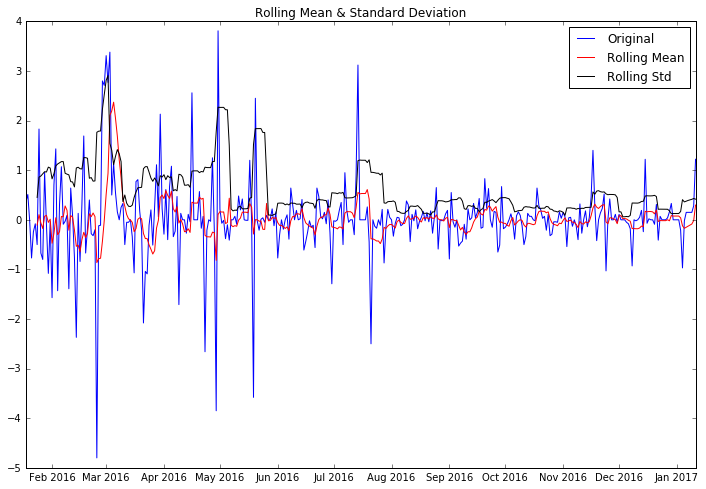

Results of Dickey-Fuller Test:
Test Statistic                -9.259303e+00
p-value                        1.421323e-15
#Lags Used                     6.000000e+00
Number of Observations Used    3.530000e+02
Critical Value (5%)           -2.869763e+00
Critical Value (1%)           -3.449011e+00
Critical Value (10%)          -2.571151e+00
dtype: float64


In [18]:
waep['seasonal_difference'] = waep['WtAvgEffPrice'] - waep['WtAvgEffPrice'].shift(7)
test_stationarity(waep['seasonal_difference'].dropna(inplace = False))

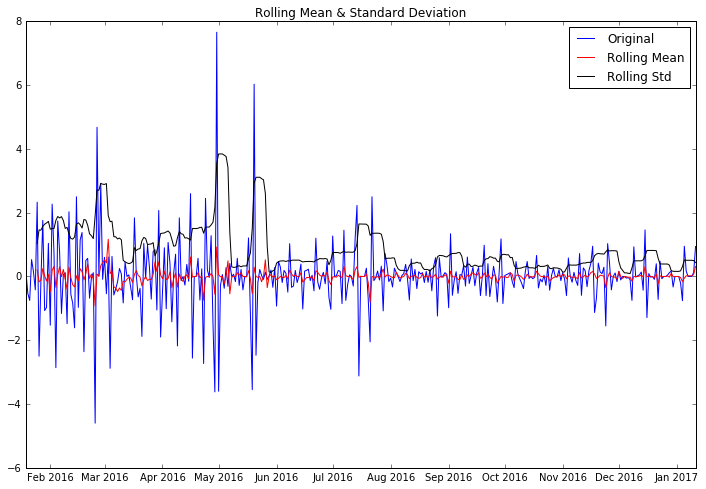

Results of Dickey-Fuller Test:
Test Statistic                -7.929276e+00
p-value                        3.548957e-12
#Lags Used                     1.500000e+01
Number of Observations Used    3.430000e+02
Critical Value (5%)           -2.870004e+00
Critical Value (1%)           -3.449560e+00
Critical Value (10%)          -2.571279e+00
dtype: float64


In [19]:
waep['seasonal_first_difference'] = waep['seasonal_difference'] - waep['seasonal_difference'].shift(1)
test_stationarity(waep['seasonal_first_difference'].dropna(inplace = False))

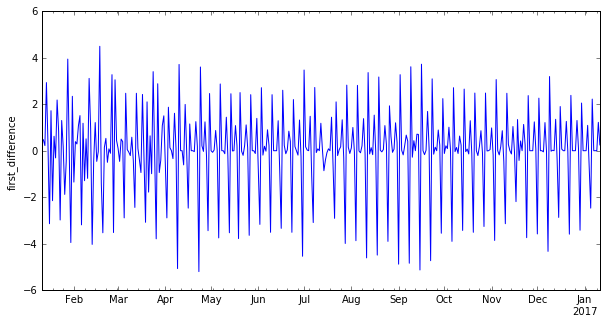

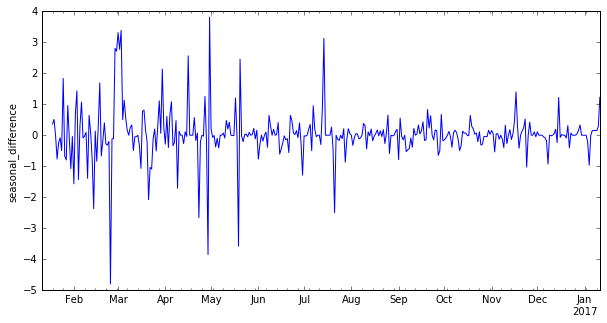

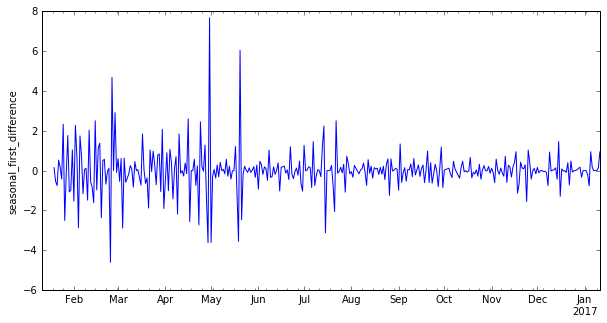

In [20]:
plt2.rcParams["figure.figsize"] = (10,5)
waep['first_difference'].plot()
plt2.ylabel('first_difference')
plt2.show()

waep['seasonal_difference'].plot()
plt2.ylabel('seasonal_difference')
plt2.show()

waep['seasonal_first_difference'].plot()
plt2.ylabel('seasonal_first_difference')
plt2.show()


## Checking autocorrelation of the data
- Checking for potential starting values for AR and MA models
- Using the 1st differenced data to plot ACF and PACF show that seasonality is messing with the data. Most probably in weekly intervals since there are 7 days with highly independent behavior

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
plt2.rcParams["figure.figsize"] = (20,10)

### QUANTITY SOLD

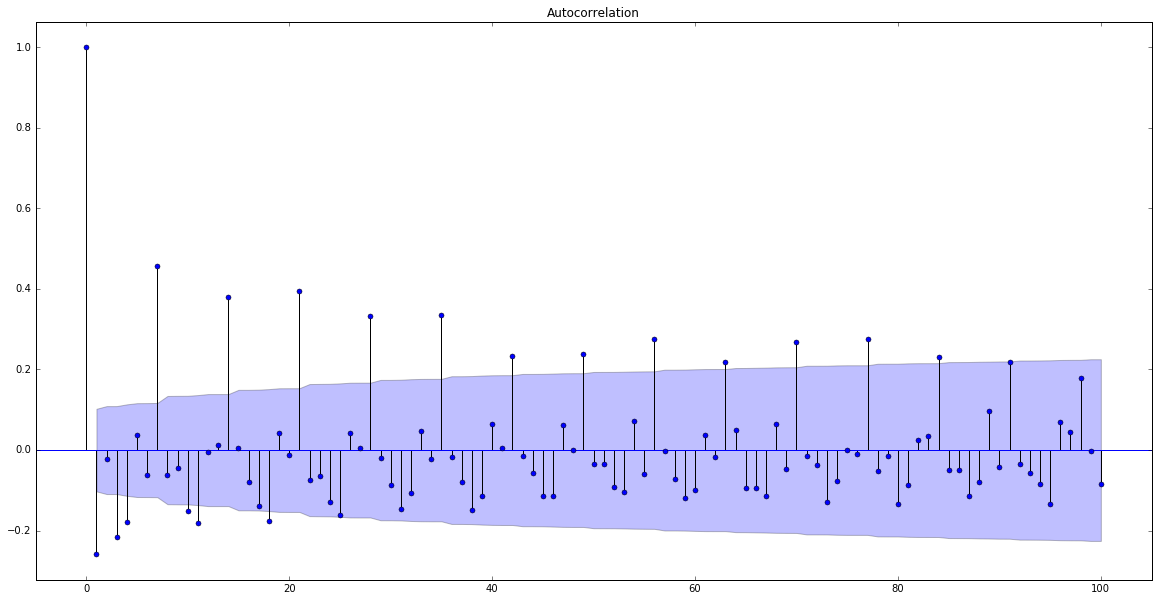

In [23]:
plot_acf(qs.iloc[:,1].dropna(inplace = False), lags = 100) #first difference... looks like seasonality is affecting this..

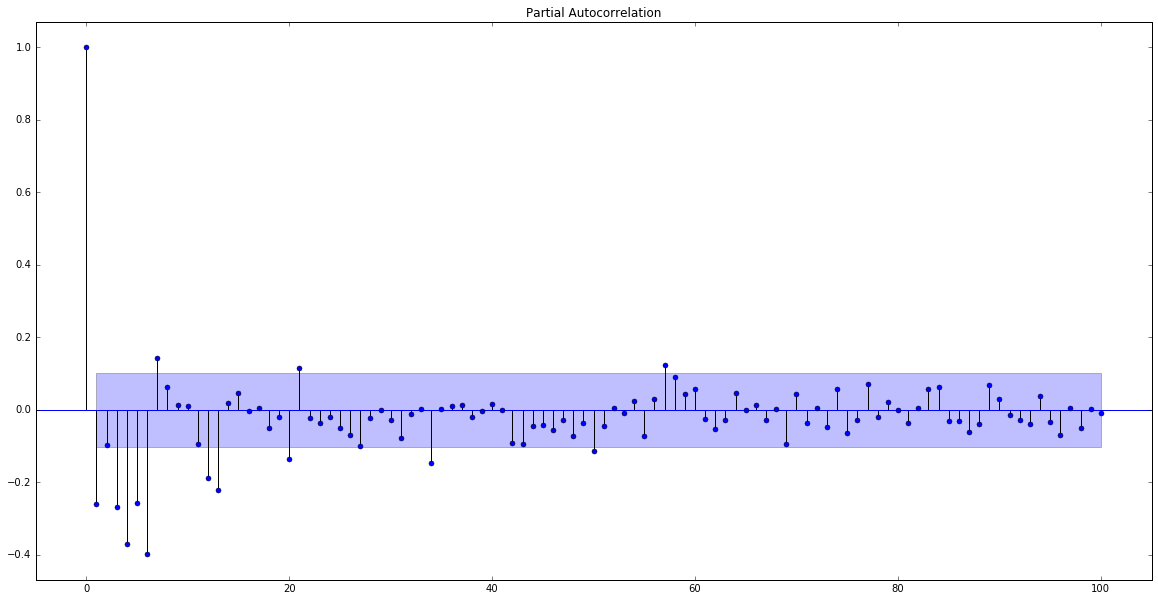

In [24]:
plot_pacf(qs.iloc[:,1].dropna(inplace = False), lags = 100) #first difference... looks like seasonality is affecting this..

- Using seasonal difference, the seasonality effects have been diminished

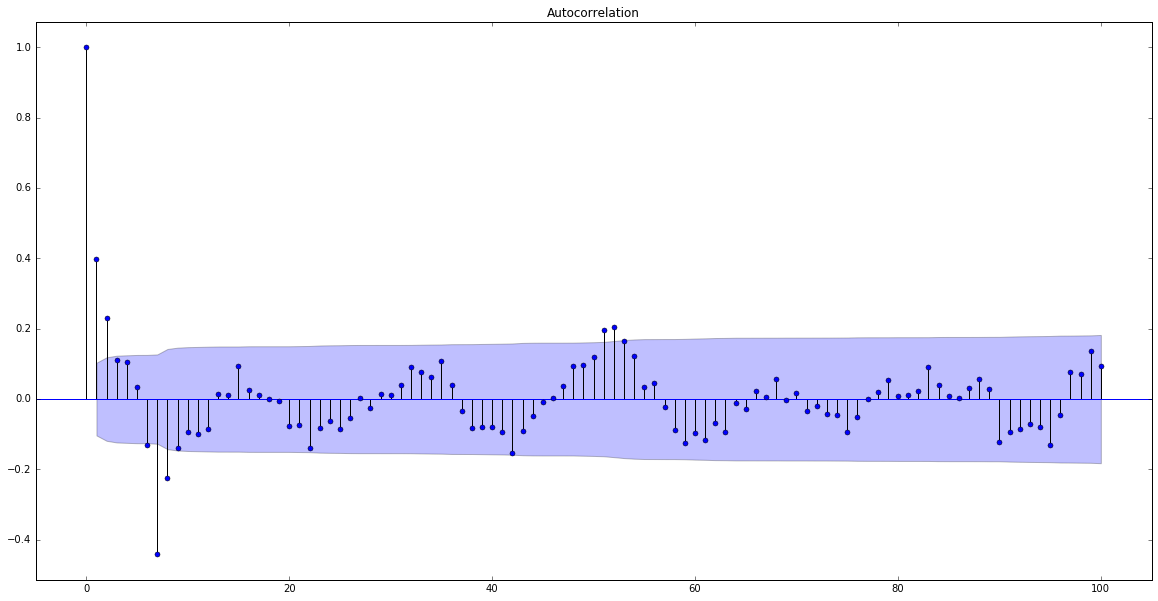

In [25]:
plot_acf(qs['seasonal_difference'].dropna(inplace = False), lags = 100)# MA = 1 or 2

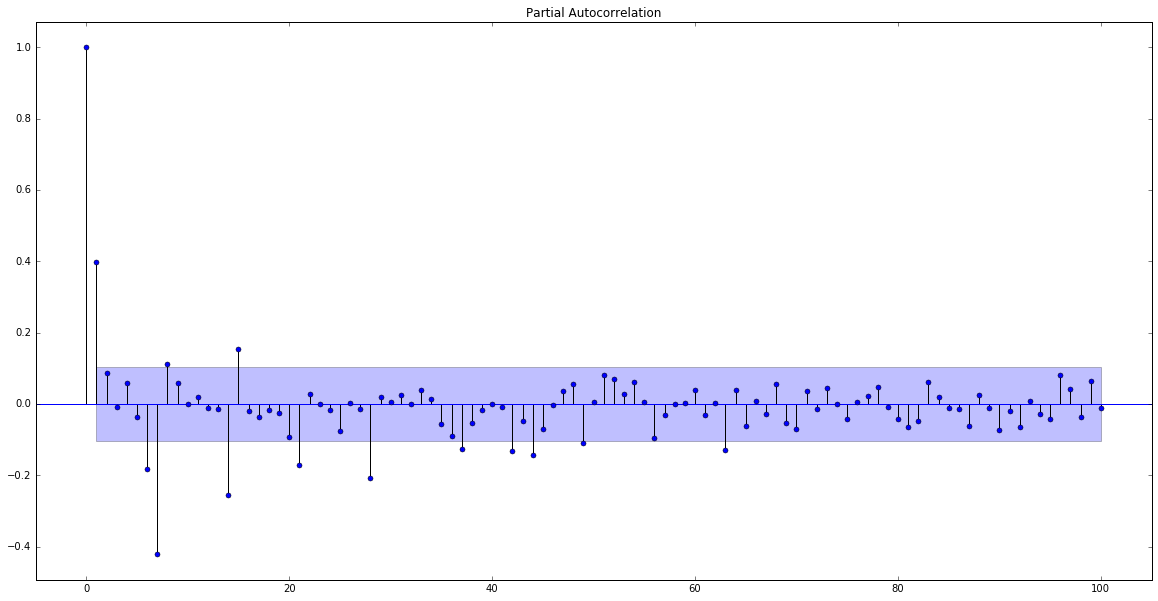

In [26]:
plot_pacf(qs['seasonal_difference'].dropna(inplace = False), lags = 100) #suggests AR 1 or 2

### Daily Shoe Rental

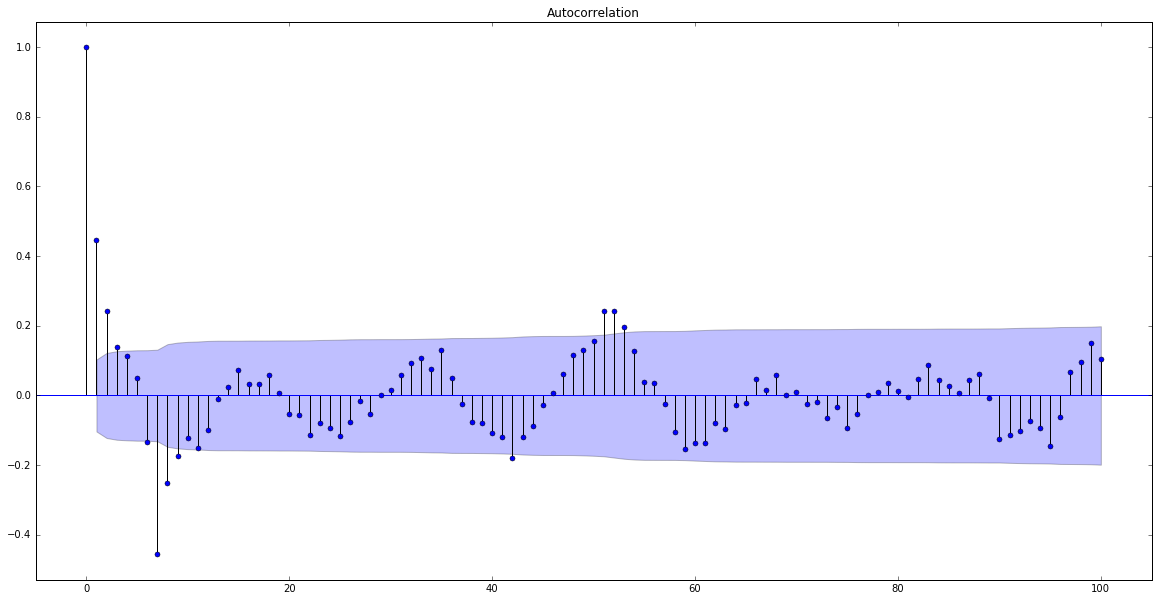

In [27]:
plot_acf(dsr['seasonal_difference'].dropna(inplace = False), lags = 100) #MA = 1 or 2

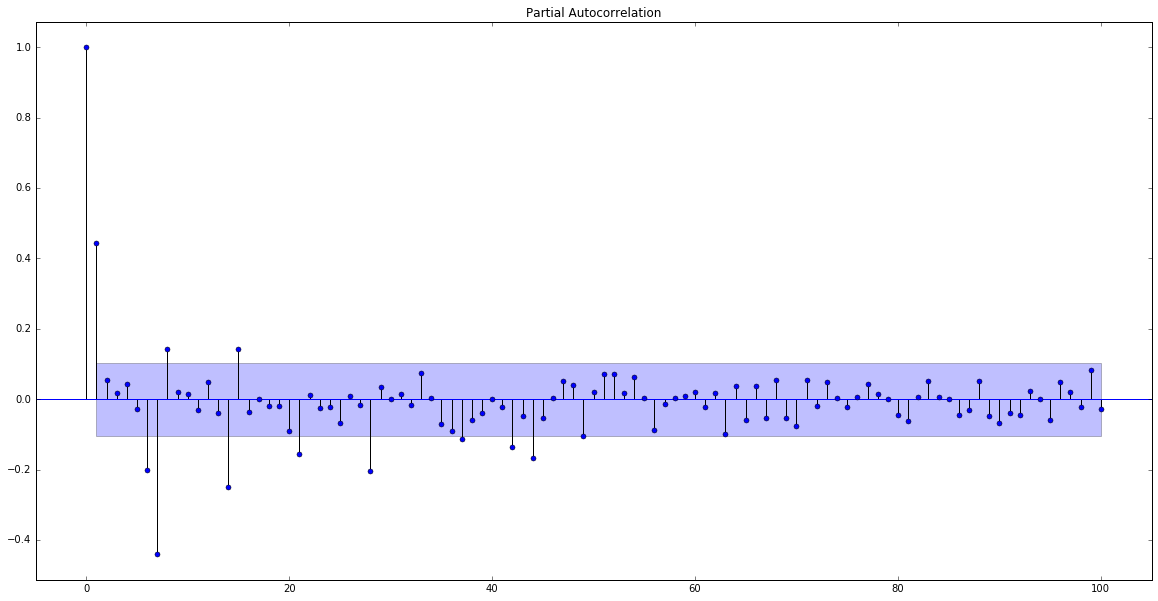

In [28]:
plot_pacf(dsr['seasonal_difference'].dropna(inplace = False), lags = 100) # AR = 1 or 2

### WtAvgEffPrice

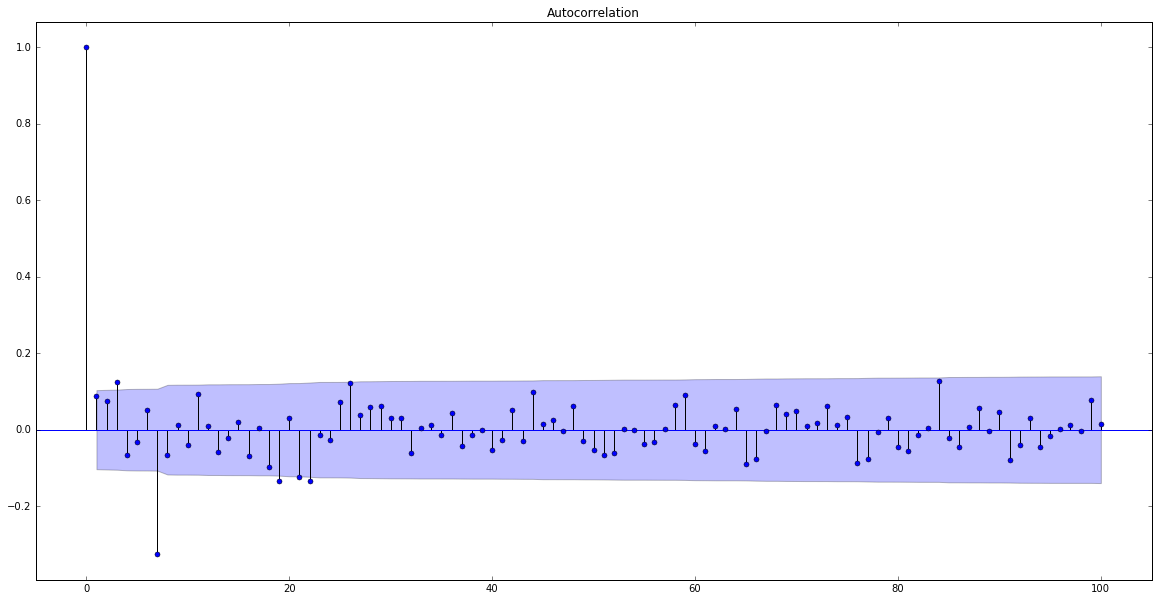

In [29]:
plot_acf(waep['seasonal_difference'].dropna(inplace = False), lags = 100) #first difference... looks like seasonality is affecting this..

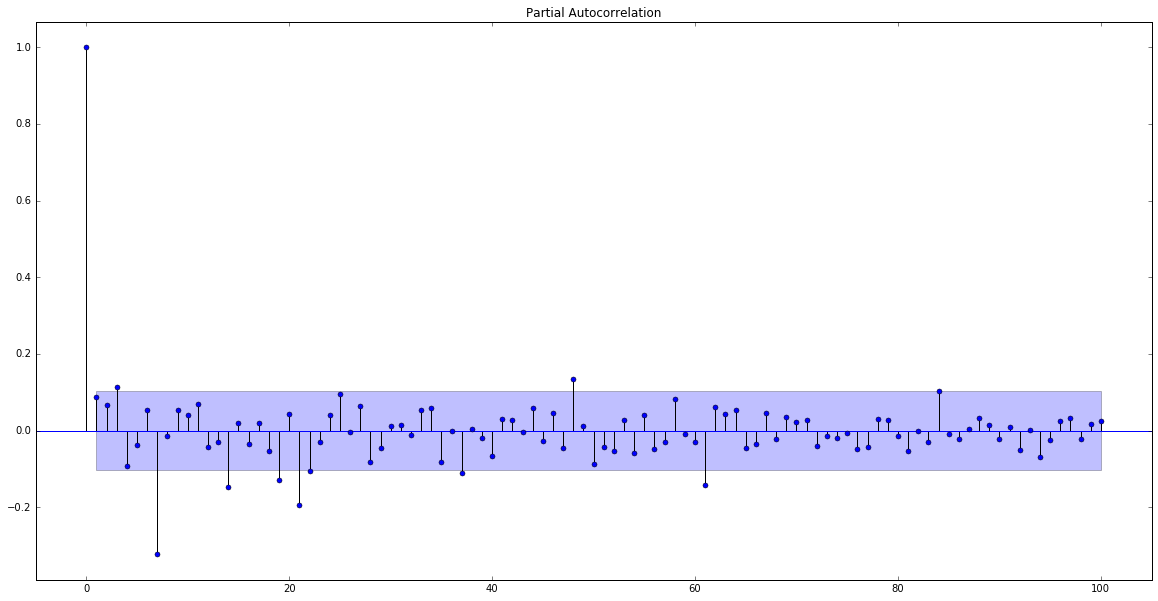

In [30]:
plot_pacf(waep['seasonal_difference'].dropna(inplace = False), lags = 100) #first difference... looks like seasonality is affecting this..

## Setting up the forecast dataframe

In [95]:
base = parser.parse(dates[-1])
new_date_list = [(base + timedelta(days=x)).strftime('%m/%d/%Y') for x in range(0, 366)]

In [156]:
base = parser.parse(dates[-1])
weekday_list = [(base + timedelta(days=x)).weekday() for x in range(0, 366)]

In [157]:
weekday_list.pop(0)

1

In [158]:
new_weekday_list = list()
for x in weekday_list:
    if x == 0:
        new_weekday_list.append(7)
    else:
        new_weekday_list.append(x)

In [160]:
new_weekday_list_adj = list()
for x in new_weekday_list:
    if x == 1:
        new_weekday_list_adj.append(7)
    else:
        new_weekday_list_adj.append(x-1)

In [98]:
new_date_list.pop(0)

'04/11/2017'

In [106]:
forecast_df = pd.DataFrame(pd.Series(new_date_list), columns =['BusinessDate'])

In [162]:
forecast_df['DayOfWeekNumber'] = pd.Series(new_weekday_list_adj)

### Split: Train/Test Set

In [32]:
qs_list = pd.DataFrame(data['Quantity Sold'].astype('float32'))
qs_list.index = pd.DatetimeIndex(freq='d', start = dates[0], periods = 367)
dsr_list = data['DailyShoeRental'].astype('float32')
dsr_list.index = pd.DatetimeIndex(freq='d', start = dates[0], periods = 367)
waep_list = data['WtAvgEffPrice'].str.strip('$').astype('float32')
waep_list.index = pd.DatetimeIndex(freq='d', start = dates[0], periods = 367)


qs_train, qs_test = qs_list[:-60], qs_list[-60:]
dsr_train, dsr_test = dsr_list[:-60], dsr_list[-60:]
waep_train, waep_test = waep_list[:-60], waep_list[-60:]
dates_train, dates_test = dates[:-60], dates[-60:]

## Predicting the next 365 days: Quantity Sold

In [50]:
qs_preds = []
qs_history = [x for x in qs_train['Quantity Sold'].tolist()]
qs_all_preds = []
for i in range(len(qs_test)):
    qs_history_series = pd.Series(qs_history) 
    diff = qs_history_series - qs_history_series.shift(7)
#     print len(diff)
    model = ARIMA(diff.dropna(inplace = False).tolist(), order = (5,0,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0][0]
    yhat = yhat + qs_history_series.tolist()[-7]
    qs_preds.append(yhat)
    obs = qs_test.iloc[i,0]
    qs_history.append(obs)
    print dates_test[i],'| predicted:', yhat, 'actual:', obs
rmse = sqrt(mean_squared_error(qs_test.iloc[:,0], qs_preds))
print 'Test RMSE: %.3f' % rmse

06/09/2017 | predicted: 187.816685436 actual: 250.0
07/09/2017 | predicted: 430.995668864 actual: 208.0
08/09/2017 | predicted: 516.328272284 actual: 465.0
09/09/2017 | predicted: 231.2996587 actual: 397.0
10/09/2017 | predicted: 1248.08100026 actual: 433.0
11/09/2017 | predicted: -152.332138921 actual: 36.0
12/09/2017 | predicted: -20.5245584235 actual: 205.0
13/09/2017 | predicted: 369.057150526 actual: 185.0
14/09/2017 | predicted: 100.714494871 actual: 22.0
15/09/2017 | predicted: 376.050509707 actual: 406.0
16/09/2017 | predicted: 466.473910455 actual: 419.0
17/09/2017 | predicted: 557.488503544 actual: 467.0
18/09/2017 | predicted: 79.3330319167 actual: 56.0
19/09/2017 | predicted: 180.912904916 actual: 253.0
20/09/2017 | predicted: 154.92054755 actual: 179.0
21/09/2017 | predicted: 2.11427461785 actual: 366.0
22/09/2017 | predicted: 512.595435922 actual: 486.0
23/09/2017 | predicted: 528.445370508 actual: 401.0
24/09/2017 | predicted: 505.046187298 actual: 497.0
25/09/2017 | pre

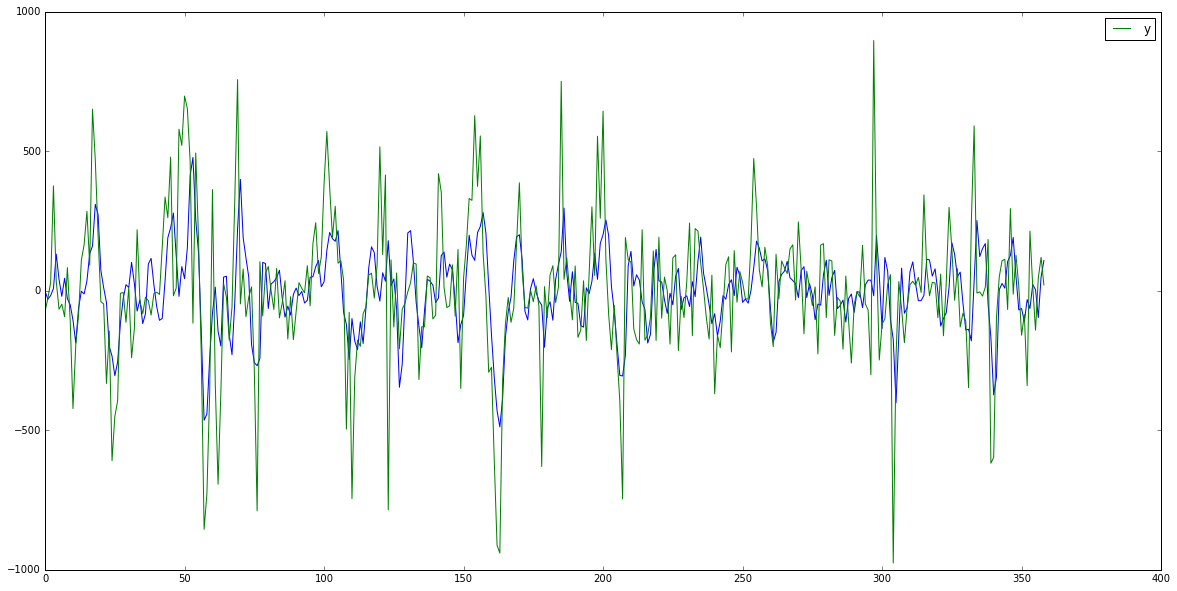

In [51]:
model_fit.plot_predict() #sample full data set prediction accuracy

In [53]:
qs_test['Forecast'] = pd.Series(qs_preds, index = qs_test.index)

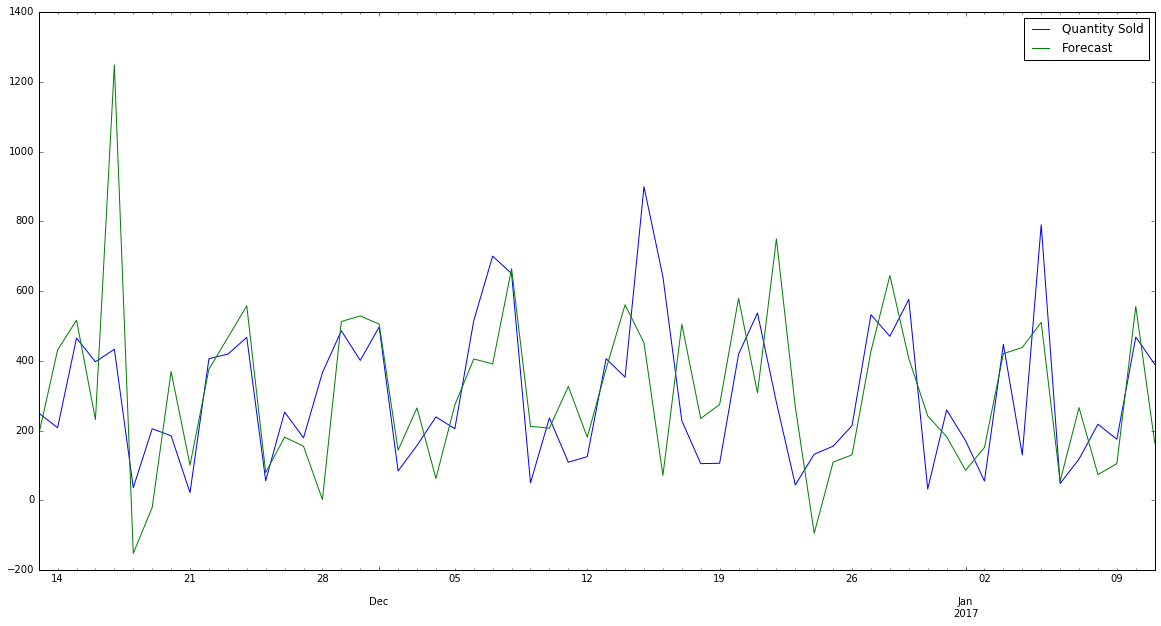

In [56]:
qs_test.plot()
plt2.show()

## Optimizing ARIMA model parameters

In [47]:
from random import randint
warnings.filterwarnings("ignore")
p_values = range(0, 5)
q_values = range(0, 5)
cvs = {}
orders = list()
for _ in range(20):
    p = randint(0,5)
    q = randint(0,5)
    order = (p,0,q)
    orders.append(order)
    
for order in orders:
    try:
        qs_preds = []
        qs_history = [x for x in qs_train['Quantity Sold'].tolist()]
        qs_all_preds = []
        for i in range(len(qs_test)):
            qs_history_series = pd.Series(qs_history) 
            diff = qs_history_series - qs_history_series.shift(7)
        #     print len(diff)
            model = ARIMA(diff.dropna(inplace = False).tolist(), order = order)
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast()[0][0]
            yhat = yhat + qs_history_series.tolist()[-7]
            qs_preds.append(yhat)
            obs = qs_test.iloc[i,0]
            qs_history.append(obs)
#             print dates_test[i],'| predicted:', yhat, 'actual:', obs
        rmse = sqrt(mean_squared_error(qs_test.iloc[:,0], qs_preds))
#         print 'Test RMSE: %.3f' % rmse
        print 'ARIMA order:', order,'Test RMSE: %.3f' % rmse
        cvs[str(order)] = rmse
    except:
        print 'Error or did not converge'

ARIMA order: (3, 0, 5) Test RMSE: 187.056
ARIMA order: (3, 0, 2) Test RMSE: 229.677
ARIMA order: (0, 0, 0) Test RMSE: 229.666
ARIMA order: (5, 0, 2) Test RMSE: 215.750
ARIMA order: (5, 0, 1) Test RMSE: 226.620
ARIMA order: (3, 0, 5) Test RMSE: 187.056
ARIMA order: (5, 0, 5) Test RMSE: 184.960
ARIMA order: (2, 0, 4) Test RMSE: 216.430
ARIMA order: (0, 0, 0) Test RMSE: 229.666
ARIMA order: (1, 0, 4) Test RMSE: 235.203
ARIMA order: (1, 0, 3) Test RMSE: 234.445
ARIMA order: (5, 0, 2) Test RMSE: 215.750
ARIMA order: (0, 0, 3) Test RMSE: 234.813
ARIMA order: (0, 0, 1) Test RMSE: 223.232
ARIMA order: (3, 0, 5) Test RMSE: 187.056
ARIMA order: (3, 0, 4) Test RMSE: 213.755
ARIMA order: (3, 0, 5) Test RMSE: 187.056
ARIMA order: (3, 0, 1) Test RMSE: 228.502
ARIMA order: (5, 0, 5) Test RMSE: 184.960
ARIMA order: (5, 0, 3) Test RMSE: 210.561


- Based on the optimization run, it looks like we can still squeeze a few more points of accuracy by changing the model parameters to (5,0,5) -> p = 5, q = 5

In [48]:
for key, value in sorted(cvs.iteritems(), key=lambda (k,v): (v,k)):
    print "%s: %s" % (key, value)

(5, 0, 5): 184.96045837
(3, 0, 5): 187.055800619
(5, 0, 3): 210.560782257
(3, 0, 4): 213.755475473
(5, 0, 2): 215.750107564
(2, 0, 4): 216.430077791
(0, 0, 1): 223.231697833
(5, 0, 1): 226.619838484
(3, 0, 1): 228.501634698
(0, 0, 0): 229.666149717
(3, 0, 2): 229.676688018
(1, 0, 3): 234.444775272
(0, 0, 3): 234.812797412
(1, 0, 4): 235.203495312


In [57]:
qs_preds = []
qs_history = [x for x in qs_train['Quantity Sold'].tolist()]
qs_all_preds = []
for i in range(len(qs_test)):
    qs_history_series = pd.Series(qs_history) 
    diff = qs_history_series - qs_history_series.shift(7)
#     print len(diff)
    model = ARIMA(diff.dropna(inplace = False).tolist(), order = (5,0,5))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0][0]
    yhat = yhat + qs_history_series.tolist()[-7]
    qs_preds.append(yhat)
    obs = qs_test.iloc[i,0]
    qs_history.append(obs)
    print dates_test[i],'| predicted:', yhat, 'actual:', obs
rmse = sqrt(mean_squared_error(qs_test.iloc[:,0], qs_preds))
print 'Test RMSE: %.3f' % rmse

06/09/2017 | predicted: 161.167055311 actual: 250.0
07/09/2017 | predicted: 202.246758912 actual: 208.0
08/09/2017 | predicted: 764.220663286 actual: 465.0
09/09/2017 | predicted: 302.480736008 actual: 397.0
10/09/2017 | predicted: 985.539225769 actual: 433.0
11/09/2017 | predicted: -20.6301935163 actual: 36.0
12/09/2017 | predicted: 85.8349825552 actual: 205.0
13/09/2017 | predicted: 272.0837671 actual: 185.0
14/09/2017 | predicted: 79.6592665625 actual: 22.0
15/09/2017 | predicted: 326.707777172 actual: 406.0
16/09/2017 | predicted: 528.432762562 actual: 419.0
17/09/2017 | predicted: 593.238098136 actual: 467.0
18/09/2017 | predicted: -52.3849089244 actual: 56.0
19/09/2017 | predicted: 98.130161779 actual: 253.0
20/09/2017 | predicted: 259.900389528 actual: 179.0
21/09/2017 | predicted: 49.6610656106 actual: 366.0
22/09/2017 | predicted: 416.184647508 actual: 486.0
23/09/2017 | predicted: 619.988314522 actual: 401.0
24/09/2017 | predicted: 596.755807023 actual: 497.0
25/09/2017 | pre

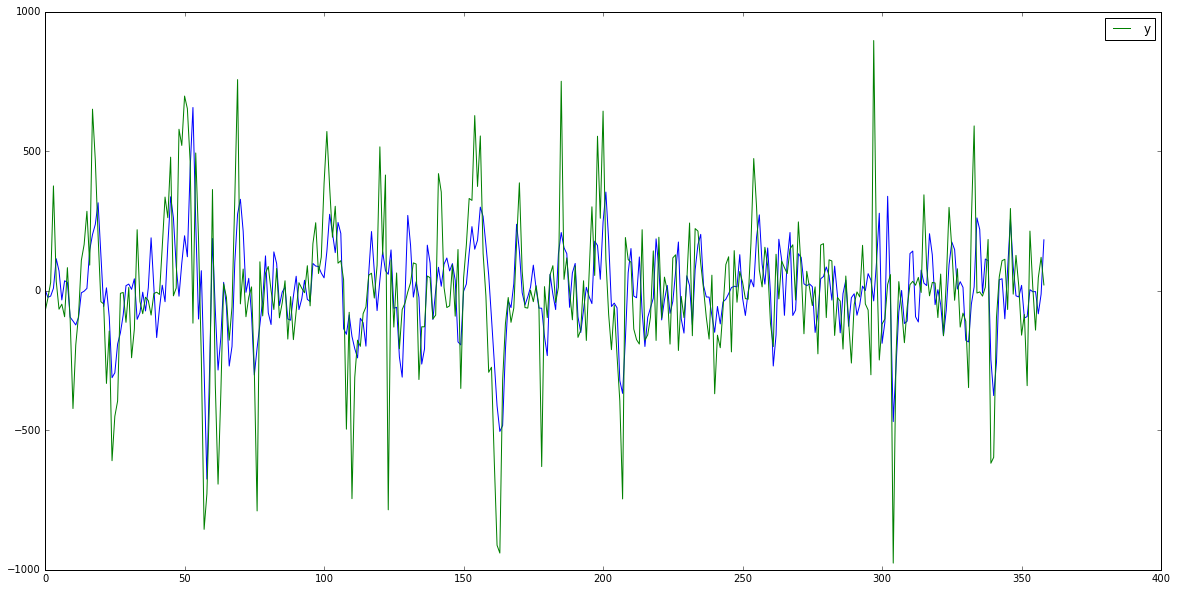

In [59]:
model_fit.plot_predict() #sample full data set prediction accuracy

In [60]:
qs_test['Forecast'] = pd.Series(qs_preds, index = qs_test.index)

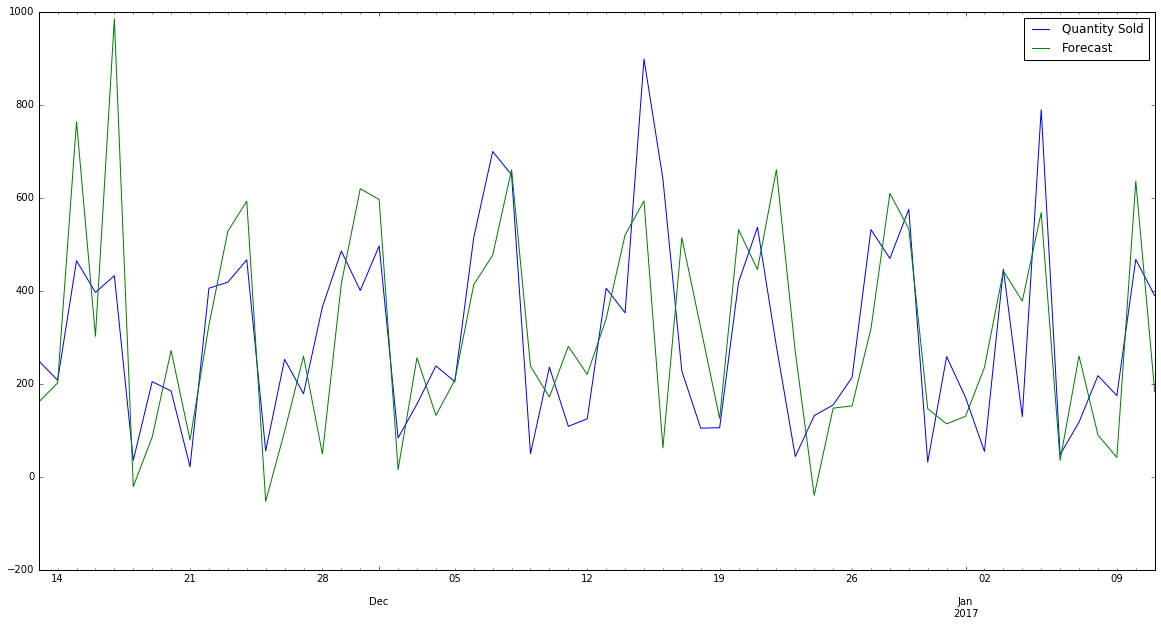

In [62]:
qs_test.plot()
plt2.show()

In [69]:
qs_forecast = []
qs_history_series = pd.Series(qs_history) 
diff = qs_history_series - qs_history_series.shift(7)
model = ARIMA(diff.dropna(inplace = False).tolist(), order = (5,0,5))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast(steps = 365)
# yhat = yhat + qs_history_series.tolist()[-7]

    


In [79]:
new_qs_history = [x for x in qs_history]
day = 1
for f in yhat[0]:
    value = f + new_qs_history[-7]
    print 'Day', day, ':', int(value)
    new_qs_history.append(value)
    day+= 1

Day 1 : 743
Day 2 : 143
Day 3 : 193
Day 4 : 183
Day 5 : 161
Day 6 : 480
Day 7 : 390
Day 8 : 701
Day 9 : 136
Day 10 : 204
Day 11 : 197
Day 12 : 149
Day 13 : 482
Day 14 : 388
Day 15 : 703
Day 16 : 122
Day 17 : 204
Day 18 : 193
Day 19 : 152
Day 20 : 474
Day 21 : 390
Day 22 : 698
Day 23 : 124
Day 24 : 197
Day 25 : 194
Day 26 : 146
Day 27 : 476
Day 28 : 384
Day 29 : 699
Day 30 : 118
Day 31 : 198
Day 32 : 189
Day 33 : 147
Day 34 : 470
Day 35 : 385
Day 36 : 694
Day 37 : 119
Day 38 : 192
Day 39 : 189
Day 40 : 142
Day 41 : 470
Day 42 : 380
Day 43 : 694
Day 44 : 114
Day 45 : 192
Day 46 : 184
Day 47 : 142
Day 48 : 466
Day 49 : 380
Day 50 : 689
Day 51 : 114
Day 52 : 188
Day 53 : 184
Day 54 : 138
Day 55 : 465
Day 56 : 376
Day 57 : 689
Day 58 : 109
Day 59 : 187
Day 60 : 180
Day 61 : 137
Day 62 : 461
Day 63 : 375
Day 64 : 685
Day 65 : 108
Day 66 : 184
Day 67 : 179
Day 68 : 133
Day 69 : 460
Day 70 : 371
Day 71 : 684
Day 72 : 105
Day 73 : 182
Day 74 : 175
Day 75 : 132
Day 76 : 457
Day 77 : 370
Day 78 :

In [107]:
forecast_qs = [int(x) for x in new_qs_history[-365:]]
forecast_df['Quantity Sold Forecast'] = pd.Series(forecast_qs)

In [108]:
forecast_df

,BusinessDate,Quantity Sold Forecast
0,04/12/2017,743
1,04/13/2017,143
2,04/14/2017,193
3,04/15/2017,183
4,04/16/2017,161
5,04/17/2017,480
6,04/18/2017,390
7,04/19/2017,701
8,04/20/2017,136
9,04/21/2017,204


## Predicting the next 365 days: Daily Shoe Rentals

In [117]:
dsr_test = pd.DataFrame(dsr_test, columns = ['DailyShoeRental'])

In [119]:
dsr_preds = []
dsr_history = [x for x in dsr_train.tolist()]
dsr_all_preds = []
for i in range(len(dsr_test)):
    dsr_history_series = pd.Series(dsr_history) 
    diff = dsr_history_series - dsr_history_series.shift(7)
#     print len(diff)
    model = ARIMA(diff.dropna(inplace = False).tolist(), order = (5,0,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0][0]
    yhat = yhat + dsr_history_series.tolist()[-7]
    dsr_preds.append(yhat)
    obs = dsr_test.iloc[i,0]
    dsr_history.append(obs)
    print dates_test[i],'| predicted:', yhat, 'actual:', obs
rmse = sqrt(mean_squared_error(dsr_test.iloc[:,0], dsr_preds))
print 'Test RMSE: %.3f' % rmse

06/09/2017 | predicted: 94.5651918158 actual: 131.0
07/09/2017 | predicted: 247.32463005 actual: 103.0
08/09/2017 | predicted: 269.130028237 actual: 286.0
09/09/2017 | predicted: 131.5701311 actual: 259.0
10/09/2017 | predicted: 773.970305897 actual: 245.0
11/09/2017 | predicted: -141.394117679 actual: 28.0
12/09/2017 | predicted: 11.6592936318 actual: 80.0
13/09/2017 | predicted: 202.126587943 actual: 92.0
14/09/2017 | predicted: 18.222852742 actual: 15.0
15/09/2017 | predicted: 225.306125345 actual: 226.0
16/09/2017 | predicted: 277.616183803 actual: 291.0
17/09/2017 | predicted: 321.410361473 actual: 264.0
18/09/2017 | predicted: 73.5886862967 actual: 23.0
19/09/2017 | predicted: 74.0517557749 actual: 127.0
20/09/2017 | predicted: 91.1173739016 actual: 92.0
21/09/2017 | predicted: 2.43291115132 actual: 246.0
22/09/2017 | predicted: 292.908163013 actual: 286.0
23/09/2017 | predicted: 352.527385566 actual: 258.0
24/09/2017 | predicted: 282.818031079 actual: 283.0
25/09/2017 | predicte

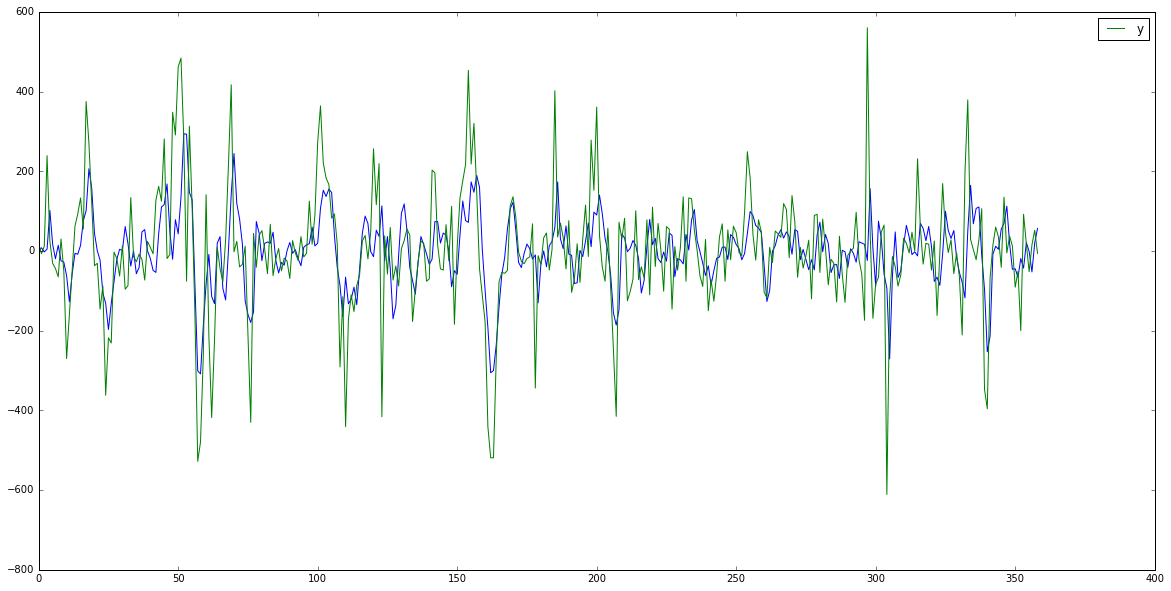

In [121]:
model_fit.plot_predict()

In [123]:
warnings.filterwarnings("ignore")
for order in orders:
    try:
        dsr_preds = []
        dsr_history = [x for x in dsr_train.tolist()]
        dsr_all_preds = []
        for i in range(len(dsr_test)):
            dsr_history_series = pd.Series(dsr_history) 
            diff = dsr_history_series - dsr_history_series.shift(7)
        #     print len(diff)
            model = ARIMA(diff.dropna(inplace = False).tolist(), order = (5,0,2))
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast()[0][0]
            yhat = yhat + dsr_history_series.tolist()[-7]
            dsr_preds.append(yhat)
            obs = dsr_test.iloc[i,0]
            dsr_history.append(obs)
#             print dates_test[i],'| predicted:', yhat, 'actual:', obs
        rmse = sqrt(mean_squared_error(dsr_test.iloc[:,0], dsr_preds))
#         print 'Test RMSE: %.3f' % rmse
        print 'ARIMA order:', order,'Test RMSE: %.3f' % rmse
        cvs[str(order)] = rmse
    except:
        print 'Error or did not converge'

ARIMA order: (3, 0, 5) Test RMSE: 133.152
ARIMA order: (3, 0, 2) Test RMSE: 133.152
ARIMA order: (0, 0, 0) Test RMSE: 133.152
ARIMA order: (5, 0, 2) Test RMSE: 133.152
ARIMA order: (5, 0, 1) Test RMSE: 133.152
ARIMA order: (3, 0, 5) Test RMSE: 133.152
ARIMA order: (5, 0, 5) Test RMSE: 133.152
ARIMA order: (2, 0, 4) Test RMSE: 133.152
ARIMA order: (0, 0, 0) Test RMSE: 133.152
ARIMA order: (1, 0, 4) Test RMSE: 133.152
ARIMA order: (1, 0, 3) Test RMSE: 133.152
ARIMA order: (5, 0, 2) Test RMSE: 133.152
ARIMA order: (0, 0, 3) Test RMSE: 133.152
ARIMA order: (0, 0, 1) Test RMSE: 133.152
ARIMA order: (3, 0, 5) Test RMSE: 133.152
ARIMA order: (3, 0, 4) Test RMSE: 133.152
ARIMA order: (3, 0, 5) Test RMSE: 133.152
ARIMA order: (3, 0, 1) Test RMSE: 133.152
ARIMA order: (5, 0, 5) Test RMSE: 133.152
ARIMA order: (5, 0, 3) Test RMSE: 133.152


In [124]:
for key, value in sorted(cvs.iteritems(), key=lambda (k,v): (v,k)):
    print "%s: %s" % (key, value)

(0, 0, 0): 133.151570613
(0, 0, 1): 133.151570613
(0, 0, 3): 133.151570613
(1, 0, 3): 133.151570613
(1, 0, 4): 133.151570613
(2, 0, 4): 133.151570613
(3, 0, 1): 133.151570613
(3, 0, 2): 133.151570613
(3, 0, 4): 133.151570613
(3, 0, 5): 133.151570613
(5, 0, 1): 133.151570613
(5, 0, 2): 133.151570613
(5, 0, 3): 133.151570613
(5, 0, 5): 133.151570613


In [125]:
dsr_forecast = []
dsr_history_series = pd.Series(dsr_history) 
diff = dsr_history_series - dsr_history_series.shift(7)
model = ARIMA(diff.dropna(inplace = False).tolist(), order = (5,0,5))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast(steps = 365)
# yhat = yhat + qs_history_series.tolist()[-7]

    


In [126]:
new_dsr_history = [x for x in dsr_history]
day = 1
for f in yhat[0]:
    value = f + new_dsr_history[-7]
    print 'Day', day, ':', int(value)
    new_dsr_history.append(value)
    day+= 1

Day 1 : 395
Day 2 : 82
Day 3 : 93
Day 4 : 79
Day 5 : 83
Day 6 : 233
Day 7 : 246
Day 8 : 371
Day 9 : 85
Day 10 : 96
Day 11 : 94
Day 12 : 74
Day 13 : 242
Day 14 : 244
Day 15 : 382
Day 16 : 77
Day 17 : 103
Day 18 : 91
Day 19 : 84
Day 20 : 237
Day 21 : 253
Day 22 : 378
Day 23 : 86
Day 24 : 99
Day 25 : 99
Day 26 : 80
Day 27 : 245
Day 28 : 249
Day 29 : 386
Day 30 : 83
Day 31 : 107
Day 32 : 95
Day 33 : 88
Day 34 : 242
Day 35 : 256
Day 36 : 383
Day 37 : 90
Day 38 : 104
Day 39 : 103
Day 40 : 85
Day 41 : 249
Day 42 : 254
Day 43 : 390
Day 44 : 87
Day 45 : 110
Day 46 : 100
Day 47 : 92
Day 48 : 247
Day 49 : 260
Day 50 : 388
Day 51 : 94
Day 52 : 108
Day 53 : 107
Day 54 : 90
Day 55 : 253
Day 56 : 259
Day 57 : 394
Day 58 : 92
Day 59 : 114
Day 60 : 105
Day 61 : 96
Day 62 : 252
Day 63 : 264
Day 64 : 393
Day 65 : 98
Day 66 : 113
Day 67 : 110
Day 68 : 95
Day 69 : 257
Day 70 : 263
Day 71 : 398
Day 72 : 97
Day 73 : 118
Day 74 : 110
Day 75 : 100
Day 76 : 256
Day 77 : 268
Day 78 : 397
Day 79 : 102
Day 80 : 11

In [127]:
forecast_dsr = [int(x) for x in new_dsr_history[-365:]]
forecast_df['DailyShoeRental Forecast'] = pd.Series(forecast_dsr)

In [128]:
forecast_df

,BusinessDate,Quantity Sold Forecast,DailyShoeRental Forecast
0,04/12/2017,743,395
1,04/13/2017,143,82
2,04/14/2017,193,93
3,04/15/2017,183,79
4,04/16/2017,161,83
5,04/17/2017,480,233
6,04/18/2017,390,246
7,04/19/2017,701,371
8,04/20/2017,136,85
9,04/21/2017,204,96


## Predicting the next 365 days: Wt Avg Eff Price

In [129]:
waep_test = pd.DataFrame(waep_test, columns = ['WtAvgEffPrice'])

In [130]:
waep_preds = []
waep_history = [x for x in waep_train.tolist()]
waep_all_preds = []
for i in range(len(waep_test)):
    waep_history_series = pd.Series(waep_history) 
    diff = waep_history_series - waep_history_series.shift(7)
    model = ARIMA(diff.dropna(inplace = False).tolist(), order = (5,0,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0][0]
    yhat = yhat + waep_history_series.tolist()[-7]
    waep_preds.append(yhat)
    obs = waep_test.iloc[i,0]
    waep_history.append(obs)
    print dates_test[i],'| predicted:', yhat, 'actual:', obs
rmse = sqrt(mean_squared_error(waep_test.iloc[:,0], waep_preds))
print 'Test RMSE: %.3f' % rmse

06/09/2017 | predicted: 10.4702786881 actual: 10.59
07/09/2017 | predicted: 10.6896987442 actual: 10.45
08/09/2017 | predicted: 11.2579288169 actual: 11.49
09/09/2017 | predicted: 11.3052248992 actual: 11.44
10/09/2017 | predicted: 7.63460736119 actual: 9.25
11/09/2017 | predicted: 10.7575070865 actual: 10.59
12/09/2017 | predicted: 10.6602767306 actual: 10.17
13/09/2017 | predicted: 10.680088885 actual: 10.59
14/09/2017 | predicted: 10.6477774087 actual: 10.59
15/09/2017 | predicted: 11.1684335358 actual: 11.72
16/09/2017 | predicted: 11.8714448813 actual: 11.96
17/09/2017 | predicted: 9.05376227162 actual: 8.22
18/09/2017 | predicted: 10.7042992162 actual: 10.59
19/09/2017 | predicted: 10.190321417 actual: 10.59
20/09/2017 | predicted: 10.429013777 actual: 10.59
21/09/2017 | predicted: 10.8127508342 actual: 10.59
22/09/2017 | predicted: 11.6435936468 actual: 11.83
23/09/2017 | predicted: 12.0787501846 actual: 11.91
24/09/2017 | predicted: 8.21083461002 actual: 8.33
25/09/2017 | predi

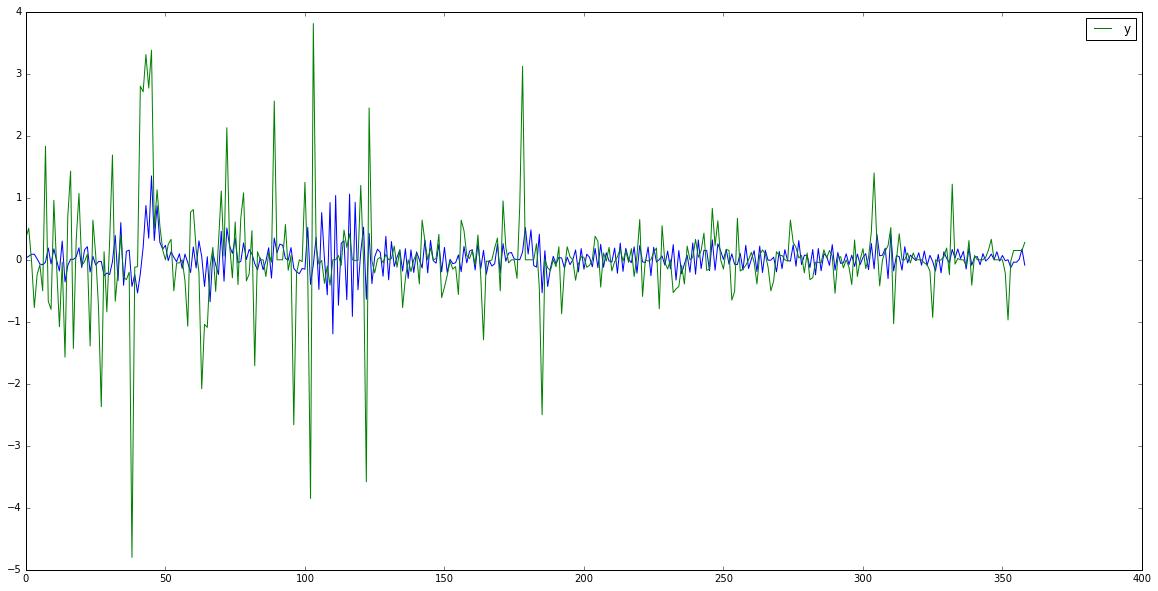

In [131]:
model_fit.plot_predict()

In [133]:
warnings.filterwarnings("ignore")
for order in orders:
    try:
        waep_preds = []
        waep_history = [x for x in waep_train.tolist()]
        waep_all_preds = []
        for i in range(len(waep_test)):
            waep_history_series = pd.Series(waep_history) 
            diff = waep_history_series - waep_history_series.shift(7)
        #     print len(diff)
            model = ARIMA(diff.dropna(inplace = False).tolist(), order = (5,0,2))
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast()[0][0]
            yhat = yhat + waep_history_series.tolist()[-7]
            waep_preds.append(yhat)
            obs = waep_test.iloc[i,0]
            waep_history.append(obs)
#             print dates_test[i],'| predicted:', yhat, 'actual:', obs
        rmse = sqrt(mean_squared_error(waep_test.iloc[:,0], waep_preds))
#         print 'Test RMSE: %.3f' % rmse
        print 'ARIMA order:', order,'Test RMSE: %.3f' % rmse
        cvs[str(order)] = rmse
    except:
        print 'Error or did not converge'

ARIMA order: (3, 0, 5) Test RMSE: 0.392
ARIMA order: (3, 0, 2) Test RMSE: 0.392
ARIMA order: (0, 0, 0) Test RMSE: 0.392
ARIMA order: (5, 0, 2) Test RMSE: 0.392
ARIMA order: (5, 0, 1) Test RMSE: 0.392
ARIMA order: (3, 0, 5) Test RMSE: 0.392
ARIMA order: (5, 0, 5) Test RMSE: 0.392
ARIMA order: (2, 0, 4) Test RMSE: 0.392
ARIMA order: (0, 0, 0) Test RMSE: 0.392
ARIMA order: (1, 0, 4) Test RMSE: 0.392
ARIMA order: (1, 0, 3) Test RMSE: 0.392
ARIMA order: (5, 0, 2) Test RMSE: 0.392
ARIMA order: (0, 0, 3) Test RMSE: 0.392
ARIMA order: (0, 0, 1) Test RMSE: 0.392
ARIMA order: (3, 0, 5) Test RMSE: 0.392
ARIMA order: (3, 0, 4) Test RMSE: 0.392
ARIMA order: (3, 0, 5) Test RMSE: 0.392
ARIMA order: (3, 0, 1) Test RMSE: 0.392
ARIMA order: (5, 0, 5) Test RMSE: 0.392
ARIMA order: (5, 0, 3) Test RMSE: 0.392


In [134]:
for key, value in sorted(cvs.iteritems(), key=lambda (k,v): (v,k)):
    print "%s: %s" % (key, value)

(0, 0, 0): 0.391541446761
(0, 0, 1): 0.391541446761
(0, 0, 3): 0.391541446761
(1, 0, 3): 0.391541446761
(1, 0, 4): 0.391541446761
(2, 0, 4): 0.391541446761
(3, 0, 1): 0.391541446761
(3, 0, 2): 0.391541446761
(3, 0, 4): 0.391541446761
(3, 0, 5): 0.391541446761
(5, 0, 1): 0.391541446761
(5, 0, 2): 0.391541446761
(5, 0, 3): 0.391541446761
(5, 0, 5): 0.391541446761


In [135]:
waep_forecast = []
waep_history_series = pd.Series(waep_history) 
diff = waep_history_series - waep_history_series.shift(7)
model = ARIMA(diff.dropna(inplace = False).tolist(), order = (5,0,5))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast(steps = 365)
# yhat = yhat + qs_history_series.tolist()[-7]

In [139]:
new_waep_history = [x for x in waep_history]
day = 1
for f in yhat[0]:
    value = f + new_waep_history[-7]
    print 'Day', day, ':', value
    new_waep_history.append(float(value))
    day+= 1

Day 1 : 8.7148274087
Day 2 : 10.9410394233
Day 3 : 11.0127145397
Day 4 : 10.7052898509
Day 5 : 10.7969069524
Day 6 : 12.0093651986
Day 7 : 12.0533211906
Day 8 : 8.76979973441
Day 9 : 11.0596842095
Day 10 : 10.9966474276
Day 11 : 10.8342645496
Day 12 : 10.8710584957
Day 13 : 11.9268210388
Day 14 : 12.1053554807
Day 15 : 8.80153882599
Day 16 : 11.0288707082
Day 17 : 11.1113364111
Day 18 : 10.8978345656
Day 19 : 10.8557874356
Day 20 : 12.0022892669
Day 21 : 12.1151605051
Day 22 : 8.77748440064
Day 23 : 11.1103850988
Day 24 : 11.1445177078
Day 25 : 10.9124593906
Day 26 : 10.9391231083
Day 27 : 12.0166101839
Day 28 : 12.11666258
Day 29 : 8.83992360966
Day 30 : 11.1229097441
Day 31 : 11.1675991056
Day 32 : 10.9844730394
Day 33 : 10.9574030166
Day 34 : 12.0415510503
Day 35 : 12.1719720299
Day 36 : 8.84882628921
Day 37 : 11.1509592581
Day 38 : 11.2232443497
Day 39 : 11.0023536965
Day 40 : 10.9942594164
Day 41 : 12.091748474
Day 42 : 12.1862137273
Day 43 : 8.8830238334
Day 44 : 11.194900338
Day

In [144]:
forecast_waep = [round(x,2) for x in new_waep_history[-365:]]
forecast_df['WtAvgEffPrice Forecast'] = pd.Series(forecast_waep)

In [146]:
forecast_df['EffectivePriceRevenue'] = forecast_df['Quantity Sold Forecast'] * forecast_df['WtAvgEffPrice Forecast']

In [164]:
forecast_df.columns.tolist()

['BusinessDate',
 'Quantity Sold Forecast',
 'DailyShoeRental Forecast',
 'WtAvgEffPrice Forecast',
 'EffectivePriceRevenue',
 'DayOfWeekNumber']

In [165]:
forecast_df = forecast_df.loc[:,['BusinessDate','DayOfWeekNumber',
 'Quantity Sold Forecast',
 'DailyShoeRental Forecast',
 'WtAvgEffPrice Forecast',
 'EffectivePriceRevenue']]

In [166]:
forecast_df

,BusinessDate,DayOfWeekNumber,Quantity Sold Forecast,DailyShoeRental Forecast,WtAvgEffPrice Forecast,EffectivePriceRevenue
0,04/12/2017,1,743,395,8.71,6471.53
1,04/13/2017,2,143,82,10.94,1564.42
2,04/14/2017,3,193,93,11.01,2124.93
3,04/15/2017,4,183,79,10.71,1959.93
4,04/16/2017,5,161,83,10.80,1738.80
5,04/17/2017,6,480,233,12.01,5764.80
6,04/18/2017,7,390,246,12.05,4699.50
7,04/19/2017,1,701,371,8.77,6147.77
8,04/20/2017,2,136,85,11.06,1504.16
9,04/21/2017,3,204,96,11.00,2244.00


In [167]:
forecast_df.to_csv('forecast.csv', index = False)

In [185]:
forecast_df.iloc[:,2:].describe()

,Quantity Sold Forecast,DailyShoeRental Forecast,WtAvgEffPrice Forecast,EffectivePriceRevenue
count,365.000000,365.000000,365.000000,365.000000
mean,264.709589,226.772603,11.751123,3002.429452
std,201.215463,113.593890,1.136107,2072.103204
min,8.000000,74.000000,8.710000,101.520000
25%,104.000000,133.000000,11.230000,1242.000000
50%,174.000000,183.000000,11.980000,1959.930000
75%,391.000000,311.000000,12.490000,5153.380000
max,743.000000,488.000000,13.720000,6471.530000


### Baseline Comparisons:
- After comparing the baseline results with the ARIMA model results, there is a big jump in accuracy of predictions

In [390]:
baseline_comparisons = pd.DataFrame.from_records([['Quantity Sold RMSE',263.33], ['DailyShoeRental RMSE',143.474], ['WtAvgEffPrice RMSE',1.553]], columns = ['Metrics', 'Baseline'])
baseline_comparisons['ARIMA Models'] = pd.Series([184.960, 133.152,0.392])
baseline_comparisons['% Improvement in Accuracy'] = 100 * (baseline_comparisons['Baseline'] - baseline_comparisons['ARIMA Models'])/baseline_comparisons['Baseline']

In [391]:
baseline_comparisons

,Metrics,Baseline,ARIMA Models,% Improvement in Accuracy
0,Quantity Sold RMSE,263.330,184.960,29.761136
1,DailyShoeRental RMSE,143.474,133.152,7.194335
2,WtAvgEffPrice RMSE,1.553,0.392,74.758532
